In [2]:
import os
import glob
os.environ["ISISROOT"] = "/usgs/pkgs/isis3.7.0/install"
os.environ["ISIS3DATA"] = "/usgs/cpkgs/isis3/data"
from pysis import isis

from plio.io import io_controlnetwork
from knoten.csm import create_csm
from scipy import sparse
import ale
import random
import csmapi
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import itertools

from knoten.bundle import *

/home/jmapel/.conda/envs/knoten/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning: ALESPICEROOT environment variable not set, Spice Drivers will not function correctly
  warnings.warn('ALESPICEROOT environment variable not set, Spice Drivers will not function correctly')


## Load in Base Network

In [3]:
cubes = '/work/projects/control_network_metrics/registration_quality/cubes.lis'
sensors = generate_sensors(cubes, directory='data/', clean=True)

In [4]:
base_net_file = '/work/projects/control_network_metrics/registration_quality/hand.net'
base_net = io_controlnetwork.from_isis(base_net_file)

network_dir = '/work/projects/control_network_metrics/registration_quality/'

## Determine Solve Parameters

In [5]:
all_parameters = {sn: get_sensor_parameters(sensor) for sn, sensor in sensors.items()} #all parameters
parameters = {sn: parameter[6:12] for sn, parameter in all_parameters.items()} #just solving for camera angles and angle velocity

## Functions

In [6]:
def compose_measure_name(measures):
    names = []
    for measure in measures:
        names.append(measure[0] + '|' + measure[1])
    return names

In [7]:
def add_error(network, num_measures, error_mag, noise_mean=None, noise_std=None):
    """
    Add error to a control network
    """
    error_net = network.copy()
    error_indices = random.sample(list(error_net.index), num_measures)
    for index in error_indices:
        error_angle = np.random.uniform(0, 2*np.pi, 1)[0]
        error_line = np.sin(error_angle) * error_mag
        error_sample = np.cos(error_angle) * error_mag
        error_net.loc[index, 'line'] += error_line
        error_net.loc[index, 'sample'] += error_sample
    
    if (noise_mean is not None) and (noise_std is not None):
        for index in [i for i in error_net.index if i not in error_indices]:
            noise_mag = np.random.normal(noise_mean, noise_std, 1)[0]
            noise_angle = np.random.uniform(0, 2*np.pi, 1)[0]
            noise_line = np.sin(noise_angle) * noise_mag
            noise_sample = np.cos(noise_angle) * noise_mag
            error_net.loc[index, 'line'] += noise_line
            error_net.loc[index, 'sample'] += noise_sample

    return error_net, error_indices

## Run a bunch of tests

In [11]:
num_tests = 1000
error_mag = 25
num_measures = 1

false_negative = np.zeros(num_tests)
found = np.zeros(num_tests)
false_positive = np.zeros(num_tests)
for i in range(num_tests):
    print(f'Running test {i+1}')
    error_net, error_indices = add_error(base_net, num_measures, error_mag)
    compute_apriori_ground_points(error_net, sensors)
    rejected_indices = data_snooping(error_net, sensors, parameters, verbose=False)
    error_set = set(error_indices)
    rejected_set = set(rejected_indices)
    false_negative[i] = len(error_set.difference(rejected_set))
    found[i] = len(error_set.intersection(rejected_set))
    false_positive[i] = len(rejected_set.difference(error_set))

Running test 1
Running test 2
Running test 3
Running test 4
Running test 5
Running test 6
Running test 7
Running test 8
Running test 9
Running test 10
Running test 11
Running test 12
Running test 13
Running test 14
Running test 15
Running test 16
Running test 17
Running test 18
Running test 19
Running test 20
Running test 21
Running test 22
Running test 23
Running test 24
Running test 25
Running test 26
Running test 27
Running test 28
Running test 29
Running test 30
Running test 31
Running test 32
Running test 33
Running test 34
Running test 35
Running test 36
Running test 37
Running test 38
Running test 39
Running test 40
Running test 41
Running test 42
Running test 43
Running test 44
Running test 45
Running test 46
Running test 47
Running test 48
Running test 49
Running test 50
Running test 51
Running test 52
Running test 53
Running test 54
Running test 55
Running test 56
Running test 57
Running test 58
Running test 59
Running test 60
Running test 61
Running test 62
Running test 63
R

Running test 490
Running test 491
Running test 492
Running test 493
Running test 494
Running test 495
Running test 496
Running test 497
Running test 498
Running test 499
Running test 500
Running test 501
Running test 502
Running test 503
Running test 504
Running test 505
Running test 506
Running test 507
Running test 508
Running test 509
Running test 510
Running test 511
Running test 512
Running test 513
Running test 514
Running test 515
Running test 516
Running test 517
Running test 518
Running test 519
Running test 520
Running test 521
Running test 522
Running test 523
Running test 524
Running test 525
Running test 526
Running test 527
Running test 528
Running test 529
Running test 530
Running test 531
Running test 532
Running test 533
Running test 534
Running test 535
Running test 536
Running test 537
Running test 538
Running test 539
Running test 540
Running test 541
Running test 542
Running test 543
Running test 544
Running test 545
Running test 546
Running test 547
Running test 5

Running test 972
Running test 973
Running test 974
Running test 975
Running test 976
Running test 977
Running test 978
Running test 979
Running test 980
Running test 981
Running test 982
Running test 983
Running test 984
Running test 985
Running test 986
Running test 987
Running test 988
Running test 989
Running test 990
Running test 991
Running test 992
Running test 993
Running test 994
Running test 995
Running test 996
Running test 997
Running test 998
Running test 999
Running test 1000


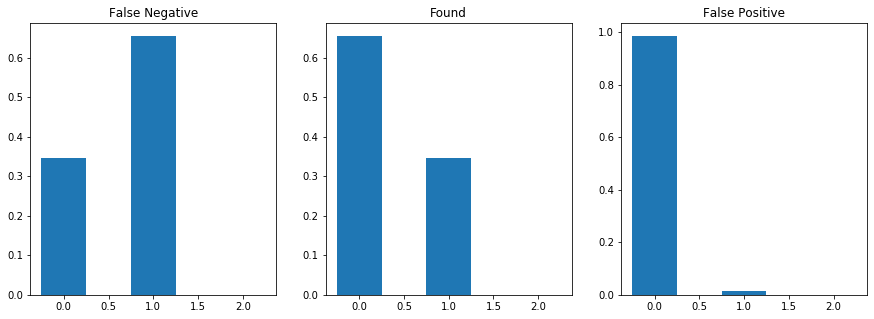

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
scaling = np.zeros_like(false_negative) + 1. / false_negative.size
ax1.set_title('False Negative')
ax1.hist(false_negative, np.arange(0, num_measures+2, 0.5) - 0.25, weights=scaling)
ax2.set_title('Found')
ax2.hist(found, np.arange(0, num_measures+2, 0.5) - 0.25, weights=scaling)
ax3.set_title('False Positive')
ax3.hist(false_positive, np.arange(0, num_measures+2, 0.5) - 0.25, weights=scaling)
plt.show()

## Run a Parameter Sweep

In [59]:
error_mag = [10, 20, 30, 40, 50]
num_errors = [1, 2, 3, 4]
num_repetitions = 500
report_step = 25
# noise = [(None, None), (0.5, 0.25), (1, 0.25)]

In [60]:
# detection_mat = np.zeros((len(error_mag), len(num_errors), len(noise)))
detections = np.zeros((len(error_mag), len(num_errors), 2))
# order is percent_found, false positive count
for i, j in itertools.product(range(len(error_mag)), range(len(num_errors))):
    print(f'Running test with {num_errors[j]} error(s) of magnitude {error_mag[i]}')
    for rep_num in range(num_repetitions):
        error_net, error_indices = add_error(base_net, num_errors[j], error_mag[i])
        compute_apriori_ground_points(error_net, sensors)
        rejected_indices = data_snooping(error_net, sensors, parameters, verbose=False)
        error_set = set(error_indices)
        rejected_set = set(rejected_indices)
        detections[i, j, 0] += len(error_set.intersection(rejected_set))
        detections[i, j, 1] += len(rejected_set.difference(error_set))
        if ((rep_num+1)%report_step == 0):
            print(f'  Finished test {rep_num+1}')
    detections[i, j, 0] /= num_errors[j]
detections /= num_repetitions

Running test with 1 error(s) of magnitude 10
  Finished test 25
  Finished test 50
  Finished test 75
  Finished test 100
  Finished test 125
  Finished test 150
  Finished test 175
  Finished test 200
  Finished test 225
  Finished test 250
  Finished test 275
  Finished test 300
  Finished test 325
  Finished test 350
  Finished test 375
  Finished test 400
  Finished test 425
  Finished test 450
  Finished test 475
  Finished test 500
Running test with 2 error(s) of magnitude 10
  Finished test 25
  Finished test 50
  Finished test 75
  Finished test 100
  Finished test 125
  Finished test 150
  Finished test 175
  Finished test 200
  Finished test 225
  Finished test 250
  Finished test 275
  Finished test 300
  Finished test 325
  Finished test 350
  Finished test 375
  Finished test 400
  Finished test 425
  Finished test 450
  Finished test 475
  Finished test 500
Running test with 3 error(s) of magnitude 10
  Finished test 25
  Finished test 50
  Finished test 75
  Finished tes

  Finished test 275
  Finished test 300
  Finished test 325
  Finished test 350
  Finished test 375
  Finished test 400
  Finished test 425
  Finished test 450
  Finished test 475
  Finished test 500
Running test with 4 error(s) of magnitude 50
  Finished test 25
  Finished test 50
  Finished test 75
  Finished test 100
  Finished test 125
  Finished test 150
  Finished test 175
  Finished test 200
  Finished test 225
  Finished test 250
  Finished test 275
  Finished test 300
  Finished test 325
  Finished test 350
  Finished test 375
  Finished test 400
  Finished test 425
  Finished test 450
  Finished test 475
  Finished test 500


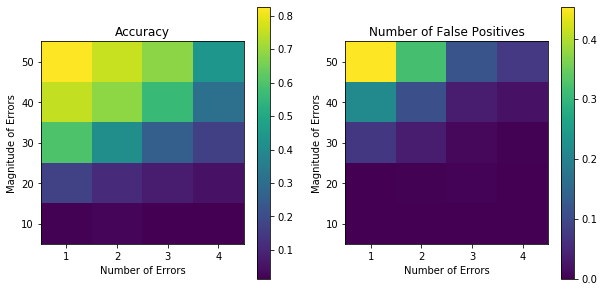

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
data_extents = [min(num_errors) - 0.5, max(num_errors) + 0.5, min(error_mag) - 5, max(error_mag) + 5]
aspect_ratio = (data_extents[1] - data_extents[0]) / (data_extents[3] - data_extents[2])
ax1.set_title('Accuracy')
ax1.set_xlabel('Number of Errors')
ax1.set_ylabel('Magnitude of Errors')
acc_plot = ax1.imshow(detections[:, :, 0], origin='lower', extent=data_extents, aspect=aspect_ratio)
fig.colorbar(acc_plot, ax=ax1)
ax2.set_title('Number of False Positives')
ax2.set_xlabel('Number of Errors')
ax2.set_ylabel('Magnitude of Errors')
positive_plot = ax2.imshow(detections[:, :, 1], origin='lower', extent=data_extents, aspect=aspect_ratio)
fig.colorbar(positive_plot, ax=ax2)
plt.show()

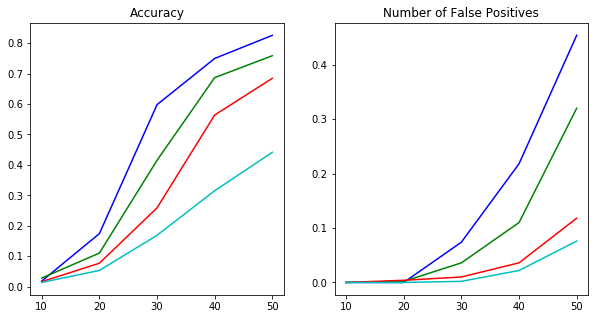

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('Accuracy')
ax1.plot(error_mag, detections[:, 0, 0], 'b')
ax1.plot(error_mag, detections[:, 1, 0], 'g')
ax1.plot(error_mag, detections[:, 2, 0], 'r')
ax1.plot(error_mag, detections[:, 3, 0], 'c')

ax2.set_title('Number of False Positives')
ax2.plot(error_mag, detections[:, 0, 1], 'b')
ax2.plot(error_mag, detections[:, 1, 1], 'g')
ax2.plot(error_mag, detections[:, 2, 1], 'r')
ax2.plot(error_mag, detections[:, 3, 1], 'c')
plt.show()